# Using the AnalyzeTimeSeries Class

This class contains a set of methods to create a database of data from KPF observations, as well as methods to ingest data, query the database, print data, and made plots of various types.  The`ingest_kpf_ts_db.py` can be used to ingest data from the command line.
        
The ingested data comes from PRIMARY header extensions of L0/2D/L1/L2 files, RV and CCF header extensions in L2 files, TELEMETRY extensions in L0 files.  

An elaborate set of standard time series plots can be made over intervals of days/months/years/decades spanning a date range.  Plots of the number of observations of a given type (e.g., flats) over time can also be produced in standardized ways.

This code is designed to be used in several ways.  First, it can be run in 'production' mode on a central server to regularly generate a set of plots showing the state of KPF and its data products to inform observers and DRP developers.  Within the KPF team, display of these plots is through the Jump web interface.  The plotting methods offer a way for KPF afficianados to quickly diagnose hardware and software issues that are evident by comparing data from different observations and to assess remedies.  This work can be done using a Jupyter Notebook or with production scripts running automatically.  All of the standard Quality Control (QC) and Diagnostics outputs generated by the DRP are ingested automatically.  Thus, users don't need to scrape FITS headers for this information.  The databases also offer a way to package derived KPF data products (e.g., RVs and metadata) into a single file for distribution and relatively easy access for analysis.

The `AnalyzeTimeSeries` class provides a front end to database methods inthe `TSDB` class.  Under the hood, `TSDB` can use either a portable SQLite3 database stored in a file or a Postgresql database configured on a server.  Distinctions between the SQLite3 and Postgresql implementations are discusssed on the related page titled "Database Details - SQLite and PostgreSQL".

This tutorial describes the basics of data ingestion, querying and display of the database, and making standardized time series plots and histograms of the number of observations vs. time.  For additional details about capabilities, the user is encouraged to read the code in `KPF-Pipeline/database/modules/src/utils/tsdb.py` and `KPF-Pipeline/modules/quick_look/src/analyze_time_series.py`.

To use `AnalyzeTimeSeries` methods, start by importing packages.

In [1]:
from modules.quicklook.src.analyze_time_series import AnalyzeTimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import subprocess
import matplotlib.dates as mdates
from datetime import datetime
from astropy.table import Table
%matplotlib inline

## Database Ingestion

The `AnalyzeTimeSeries` class is initiated as shown below.  This example uses a SQLite3 database, which is fresh because the file `kpf_ts.db` didn't exist.  When running the database in another environment, the user may want to specify a different `db_path`.

In [2]:
db_path = 'kpf_ts.db' # name of database file
myTS = AnalyzeTimeSeries(db_path=db_path)

INFO: Starting AnalyzeTimeSeries
INFO: Starting KPF_TSDB
INFO: Jupyter Notebook environment detected.
INFO: Base data directory: /data/L0
INFO: Backend: sqlite
INFO: Path of database file: /code/KPF-Pipeline/docs/source/tutorials/kpf_ts.db
INFO: Metadata table exists.
INFO: Metadata table read.
INFO: Data tables exist.


Drop the table if needed.  This is needed if the database schema was updated since it was last run.  Note that methods in `myTS.db` are part of the `TSDB` class, which is inherited by `AnalyzeTS`.

In [3]:
myTS.db.drop_tables()
myTS = AnalyzeTimeSeries(db_path=db_path)

INFO: Starting AnalyzeTimeSeries
INFO: Starting KPF_TSDB
INFO: Jupyter Notebook environment detected.
INFO: Base data directory: /data/L0
INFO: Backend: sqlite
INFO: Path of database file: /code/KPF-Pipeline/docs/source/tutorials/kpf_ts.db
INFO: Metadata table does not exist.  Attempting to create.
INFO: Metadata table created correctly with indexed columns.
INFO: Metadata table read.
INFO: Data tables do not exist.  Attempting to create.
INFO: Data tables and indices created successfully.


Data can be ingested into the database using several methods.  The first method is one observation at a time.

In [4]:
myTS.db.ingest_one_observation('/data/L0/20241003/','KP.20241003.46386.23.fits')
myTS.db.print_db_status()

INFO: Ingested observation: KP.20241003.46386.23
INFO: Database Table Summary:
INFO: Table           Columns       Rows
INFO: -----------------------------------
INFO: tsdb_base            13          1
INFO: tsdb_l0              87          1
INFO: tsdb_2d              85          1
INFO: tsdb_l1             123          1
INFO: tsdb_l1_medg        106          1
INFO: tsdb_l1_medr         97          1
INFO: tsdb_l1_stdg        106          1
INFO: tsdb_l1_stdr         97          1
INFO: tsdb_l2              17          1
INFO: tsdb_l0t            124          1
INFO: tsdb_l2rv            29          1
INFO: tsdb_l2ccf            7          1
INFO: tsdb_l2_bcv          68          1
INFO: tsdb_l2_bjd          68          1
INFO: tsdb_l2_ccfw         68          1
INFO: tsdb_l2_sci1         68          1
INFO: tsdb_l2_sci2         68          1
INFO: tsdb_l2_sci3         68          1
INFO: tsdb_l2_sci         135          1
INFO: tsdb_l2_cal         135          1
INFO: tsdb_l2_sky 

Second, a list of observations can be downloaded if the ObsIDs (e.g., 'KP.20241215.16336.39') are in the first column of a csv file.  Such files can be generated by, for example, the Jump website for those who work on the DRP development team.  The command is `myTS.add_ObsID_list_to_db('filename.csv')`.

Third, data can be ingested over a range of dates.  This command will take a few minutes to run, but rerunning it will take less time once the observations are ingested into the database.

In [5]:
start_date = '20241001'
end_date   = '20241006'
myTS = AnalyzeTimeSeries(db_path=db_path)
myTS.db.ingest_dates_to_db(start_date, end_date)

INFO: Starting AnalyzeTimeSeries
INFO: Starting KPF_TSDB
INFO: Jupyter Notebook environment detected.
INFO: Base data directory: /data/L0
INFO: Backend: sqlite
INFO: Path of database file: /code/KPF-Pipeline/docs/source/tutorials/kpf_ts.db
INFO: Metadata table exists.
INFO: Metadata table read.
INFO: Data tables exist.
INFO: Adding to database between 20241001 and 20241006


20241001:   0%|          | 0/6 [00:00<?, ?it/s]

Files:   0%|          | 0/570 [00:00<?, ?it/s]

Files:   0%|          | 0/592 [00:00<?, ?it/s]

Files:   0%|          | 0/548 [00:00<?, ?it/s]

Files:   0%|          | 0/543 [00:00<?, ?it/s]

Files:   0%|          | 0/526 [00:00<?, ?it/s]

Files:   0%|          | 0/566 [00:00<?, ?it/s]

INFO: Files for 6 days ingested/checked


After ingestion is complete, a summary of the database tables is shown.

In [6]:
myTS.db.print_db_status()

INFO: Database Table Summary:
INFO: Table           Columns       Rows
INFO: -----------------------------------
INFO: tsdb_base            13       3345
INFO: tsdb_l0              87       3345
INFO: tsdb_2d              85       3345
INFO: tsdb_l1             123       3345
INFO: tsdb_l1_medg        106       3345
INFO: tsdb_l1_medr         97       3345
INFO: tsdb_l1_stdg        106       3345
INFO: tsdb_l1_stdr         97       3345
INFO: tsdb_l2              17       3013
INFO: tsdb_l0t            124       3345
INFO: tsdb_l2rv            29       3013
INFO: tsdb_l2ccf            7       3013
INFO: tsdb_l2_bcv          68       3013
INFO: tsdb_l2_bjd          68       3013
INFO: tsdb_l2_ccfw         68       3013
INFO: tsdb_l2_sci1         68       3013
INFO: tsdb_l2_sci2         68       3013
INFO: tsdb_l2_sci3         68       3013
INFO: tsdb_l2_sci         135       3013
INFO: tsdb_l2_cal         135       3013
INFO: tsdb_l2_sky         135       3013
INFO: Dates: 6 days from 2

The other ingestion methods (not shown) include ingesting based on the ObsIDs from a file (the method `add_ObsID_list_to_db()`) and using the commandline scripts `KPF-Pipeline/scripts/ingest_dates_kpf_tsdb.py` and `KPF-Pipeline/scripts/ingest_watch_kpf_tsdb.py`.

## How the Database is Constructed
The time series database in built from the L0, 2D, L1, and L2 files associated with ObsIDs (e.g., KP.20241201.12345.67 is an ObsID for an observation on 12/01/2024).  First, a set of "derived" keywords such as the full paths to the L0-L2 files are stored in the database.  The rest of the infromation about an observation comes from reading the L0, 2D, L1, and L2 files.  The keywords to be ingested are stored in a set of .csv files in `KPF-Pipeline/static/tsdb_keywords/`.  A useful subset of keywords from the primary headers of the L0, 2D, L1, and L2 files are ingested.  Telemetry infromation is read from the TELEMETRY extension of L0 files and ingested.  Keywords from the headers to the GREEN_CCF and RV extensions of L2 files are also ingested.  Finally, the order-by-order RVs, CCF weights, and BJD times are read from the RV extension of L2 files and ingested.  This full list of columns in the database, along with data types, units, descriptions, and notes about the sources of each column can be read into a dataframe using the command `df = myTS.metadata_table_to_df()`.  One can also print this database schema using the command `myTS.print_metadata_table()`.

In [7]:
df = myTS.db.metadata_table_to_df()

## Database Querying and Display

The database can be queried and displayed.

In [8]:
myTS = AnalyzeTimeSeries(db_path=db_path)
columns_to_display = ['ObsID', 'OBJECT', 'DATE-MID', 'DRPTAGL1', 'DATAPRL0']
myTS.db.display_data(columns=columns_to_display)

INFO: Starting AnalyzeTimeSeries
INFO: Starting KPF_TSDB
INFO: Jupyter Notebook environment detected.
INFO: Base data directory: /data/L0
INFO: Backend: sqlite
INFO: Path of database file: /code/KPF-Pipeline/docs/source/tutorials/kpf_ts.db
INFO: Metadata table exists.
INFO: Metadata table read.
INFO: Data tables exist.


ObsID,OBJECT,DATE-MID,DRPTAGL1,DATAPRL0
KP.20241001.00018.07,autocal-flat-all,2024-10-01T00:00:23.084,v2.9.1,1
KP.20241001.00076.69,autocal-flat-all,2024-10-01T00:01:21.698,v2.9.1,1
KP.20241001.00134.98,autocal-flat-all,2024-10-01T00:02:19.990,v2.9.1,1
KP.20241001.00193.33,autocal-flat-all,2024-10-01T00:03:18.361,v2.9.1,1
KP.20241001.00251.84,autocal-flat-all,2024-10-01T00:04:16.841,v2.9.1,1
KP.20241001.00310.22,autocal-flat-all,2024-10-01T00:05:15.223,v2.9.1,1
KP.20241001.00368.79,autocal-flat-all,2024-10-01T00:06:13.802,v2.9.1,1
KP.20241001.00427.34,autocal-flat-all,2024-10-01T00:07:12.350,v2.9.1,1
KP.20241001.00485.94,autocal-flat-all,2024-10-01T00:08:10.947,v2.9.1,1
KP.20241001.00544.28,autocal-flat-all,2024-10-01T00:09:09.285,v2.9.1,1


Or converted into a Pandas dataframe for manipulation or for making custom plots.

## Plotting Dictionaries and YAML Files

The AnalyzeTimeSeries has a built-in plotting library that uses dictionaries to describe the elements of plots.  An example is shown below.  Note that `start_date` and `end_date` are formatted as datetime objects, not strings as above.

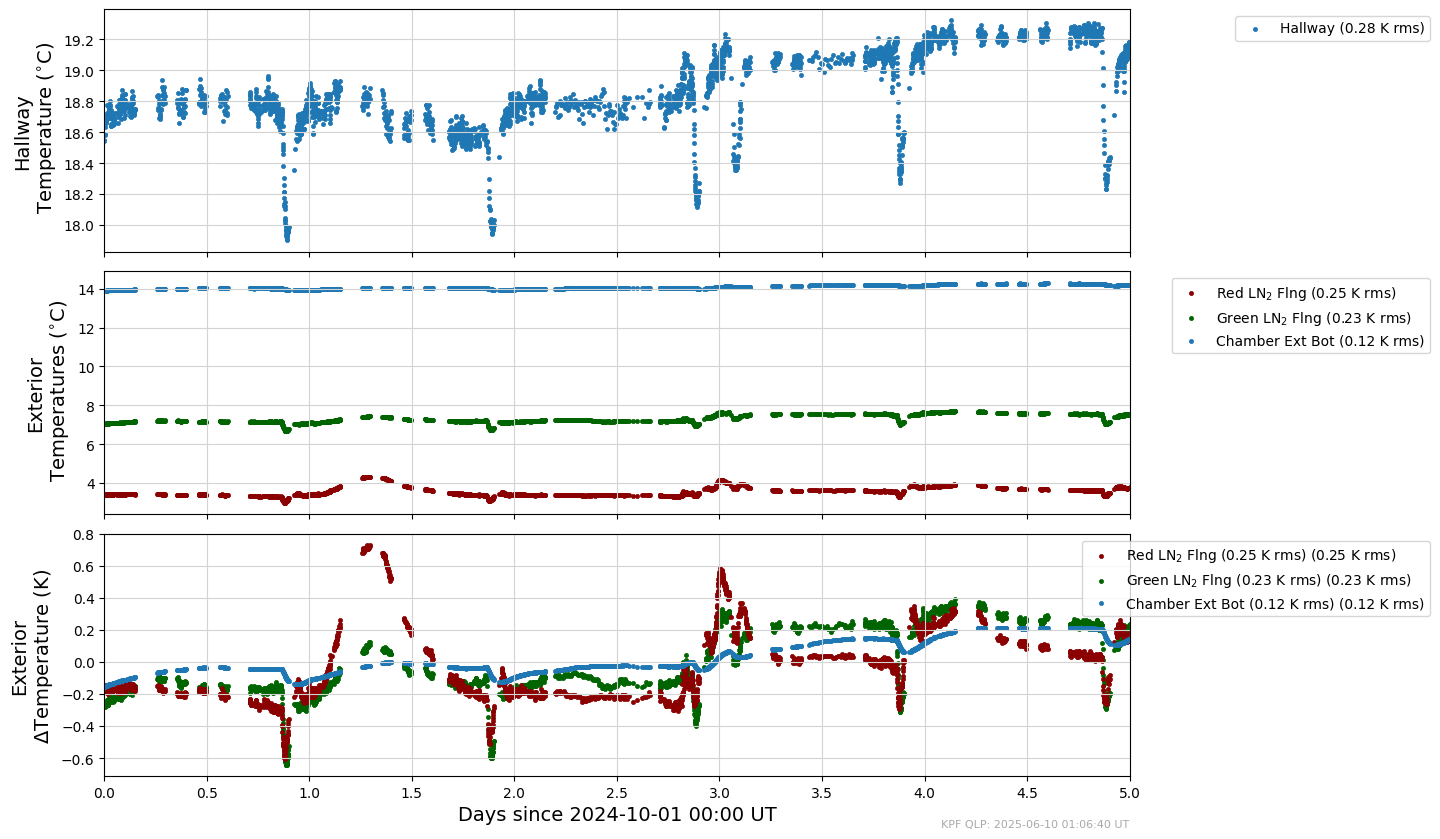

In [9]:
start_date = datetime(2024, 10,  1)
end_date   = datetime(2024, 10,  6)
dict1 = {'col': 'kpfmet.TEMP',              'plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label':  'Hallway',              'marker': '.', 'linewidth': 0.5}}
dict2 = {'col': 'kpfmet.GREEN_LN2_FLANGE',  'plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label': r'Green LN$_2$ Flng',    'marker': '.', 'linewidth': 0.5, 'color': 'darkgreen'}}
dict3 = {'col': 'kpfmet.RED_LN2_FLANGE',    'plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label': r'Red LN$_2$ Flng',      'marker': '.', 'linewidth': 0.5, 'color': 'darkred'}}
dict4 = {'col': 'kpfmet.CHAMBER_EXT_BOTTOM','plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label': r'Chamber Ext Bot',      'marker': '.', 'linewidth': 0.5}}
dict5 = {'col': 'kpfmet.CHAMBER_EXT_TOP',   'plot_type': 'plot',    'unit': 'K', 'plot_attr': {'label': r'Chamber Exterior Top', 'marker': '.', 'linewidth': 0.5}}
thispanelvars = [dict1]
thispaneldict = {'ylabel': 'Hallway\n' + r' Temperature ($^{\circ}$C)',
                 'legend_frac_size': 0.3}
halltemppanel = {'panelvars': thispanelvars,
                 'paneldict': thispaneldict}

thispanelvars2 = [dict2, dict3, dict4]
thispaneldict2 = {'ylabel': 'Exterior\n' + r' Temperatures ($^{\circ}$C)',
                 'legend_frac_size': 0.3}
halltemppanel2 = {'panelvars': thispanelvars2,
                  'paneldict': thispaneldict2}

thispanelvars3 = [dict2, dict3, dict4]
thispaneldict3 = {'ylabel': 'Exterior\n' + r'$\Delta$Temperature (K)',
                 'subtractmedian': 'true',
                 'legend_frac_size': 0.3}
halltemppanel3 = {'panelvars': thispanelvars3,
                  'paneldict': thispaneldict3}

panel_arr = [halltemppanel, halltemppanel2, halltemppanel3]

plotdict = {
             "description": "Etalon RVs (autocal)",
             "plot_type": "time_series_multipanel",
             "panel_arr": panel_arr
            }
myTS.plot_time_series_multipanel(plotdict, start_date=start_date, end_date=end_date, show_plot=True, clean=True)

The method `plot_time_series_multipanel()` above was written originally for use with dictionaries as shown above.  However, it became easier to the plotting configuration in YAML files and convert to Python dictionaries when reading the configuration.  An example of a configuration file is shown below.

In [10]:
!cat /code/KPF-Pipeline/static/tsdb_plot_configs/QC/qc_lfc.yaml

description: QC - LFC Metrics
plot_type: time_series_multipanel
panel_arr:
  - panelvars:
      - col: LFCSAT
        plot_type: state
        plot_attr:
          label: LFC Not Saturated
          marker: .
    paneldict:
      ylabel: "LFC Not Saturated\n(LFCSAT)"
      legend_frac_size: 0.15

  - panelvars:
      - col: LFC2DFOK
        plot_type: state
        plot_attr:
          label: "LFC Flux Meets Threshold\nof 4000 Counts"
          marker: .
    paneldict:
      ylabel: "LFC Flux Meets Threshold\nof 4000 Counts\n(LFC2DFOK)"
      legend_frac_size: 0.15

  - panelvars:
      - col: LFCLINES
        plot_type: state
        plot_attr:
          label: "Number and dist of\nLFC lines sufficient"
          marker: .
    paneldict:
      ylabel: "Number and dist of\nLFC lines sufficient\n(LFCLINES)"
      legend_frac_size: 0.15

  - panelvars:
      - col: LFCLGK0
        plot_type: plot
        plot_attr:
          label: "Max Good Green SKY Order"
          marker: .
         

This simple example is equivalent to the dictionary `plotdict` below.

In [11]:
dict1 = {'col': 'MONOTWLS', 
         'plot_type': 'state', 
         'plot_attr': {'label':'Montonic WLS','marker': '.'}}
thispanelvars = [dict1]
thispaneldict = {'ylabel': 'Montonic WLS',
                 'title': 'QC - Monotonic WLS in L1',
                 'legend_frac_size': 0.10}

lfcpanel = {'panelvars': thispanelvars,
            'paneldict': thispaneldict}

panel_arr = [lfcpanel]
mydict = {
    "description": "QC - Monotonic WLS in L1",
    "plot_type": "time_series_multipanel",
    "panel_arr": panel_arr
}

In [12]:
myyaml = '''description: QC - Monotonic WLS in L1
plot_type: time_series_multipanel
panel_arr:
  - panelvars:
      - col: MONOTWLS
        plot_type: state
        plot_attr:
          label: Montonic WLS
          marker: .
    paneldict:
      ylabel: Monotonic WLS
      title: QC - Monotonic WLS in L1
      legend_frac_size: 0.10
'''

Below are plots of the dictionary and yaml representations.

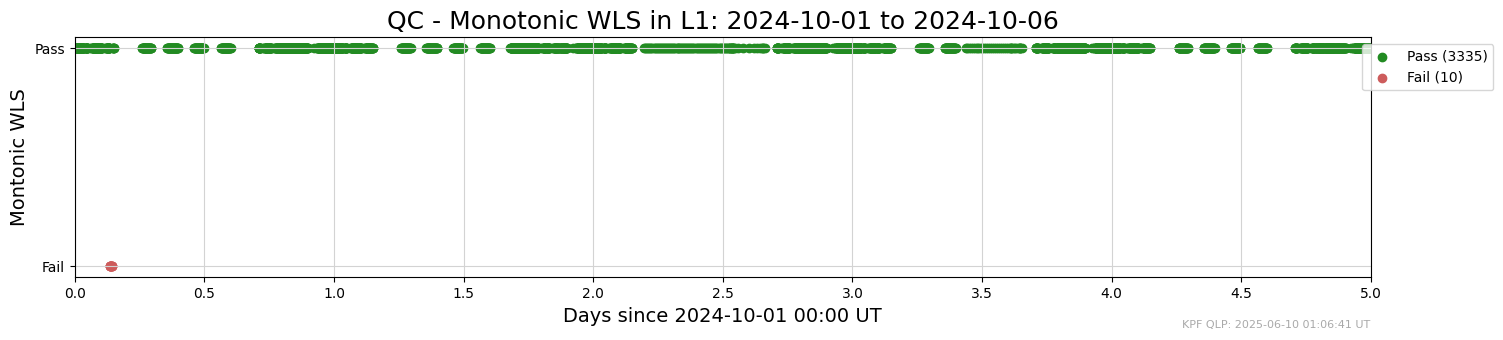

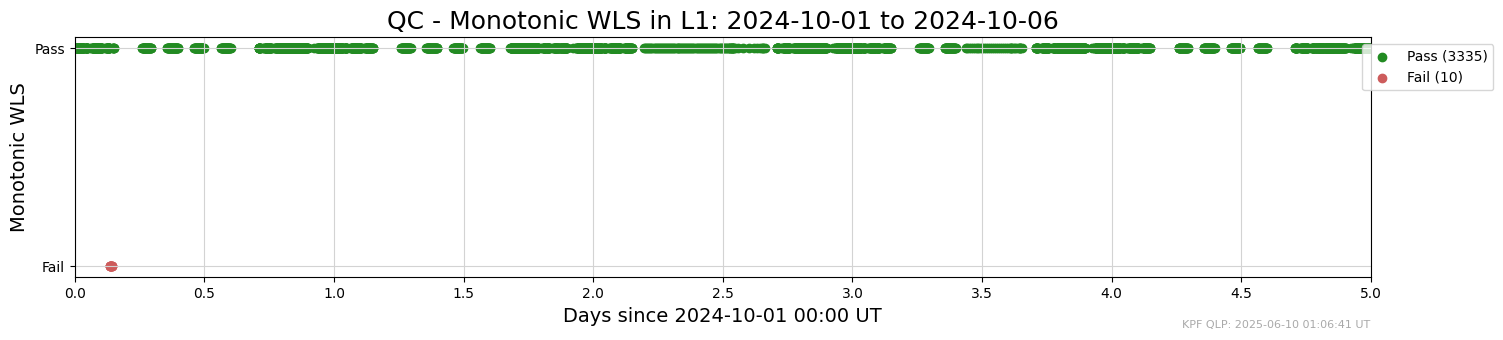

In [13]:
# Dictionary version
myTS.plot_time_series_multipanel(mydict, start_date=start_date, end_date=end_date, show_plot=True, clean=True)

# YAML version
myyaml_converted = myTS.yaml_to_dict(myyaml)
myTS.plot_time_series_multipanel(myyaml_converted, start_date=start_date, end_date=end_date, show_plot=True, clean=True)

## Plotting Telemetry
Examples of two built-in standard telemetry plots are shown below.

INFO: Plotting from config: /code/KPF-Pipeline/static/tsdb_plot_configs/Chamber/chamber_temp_detail.yaml


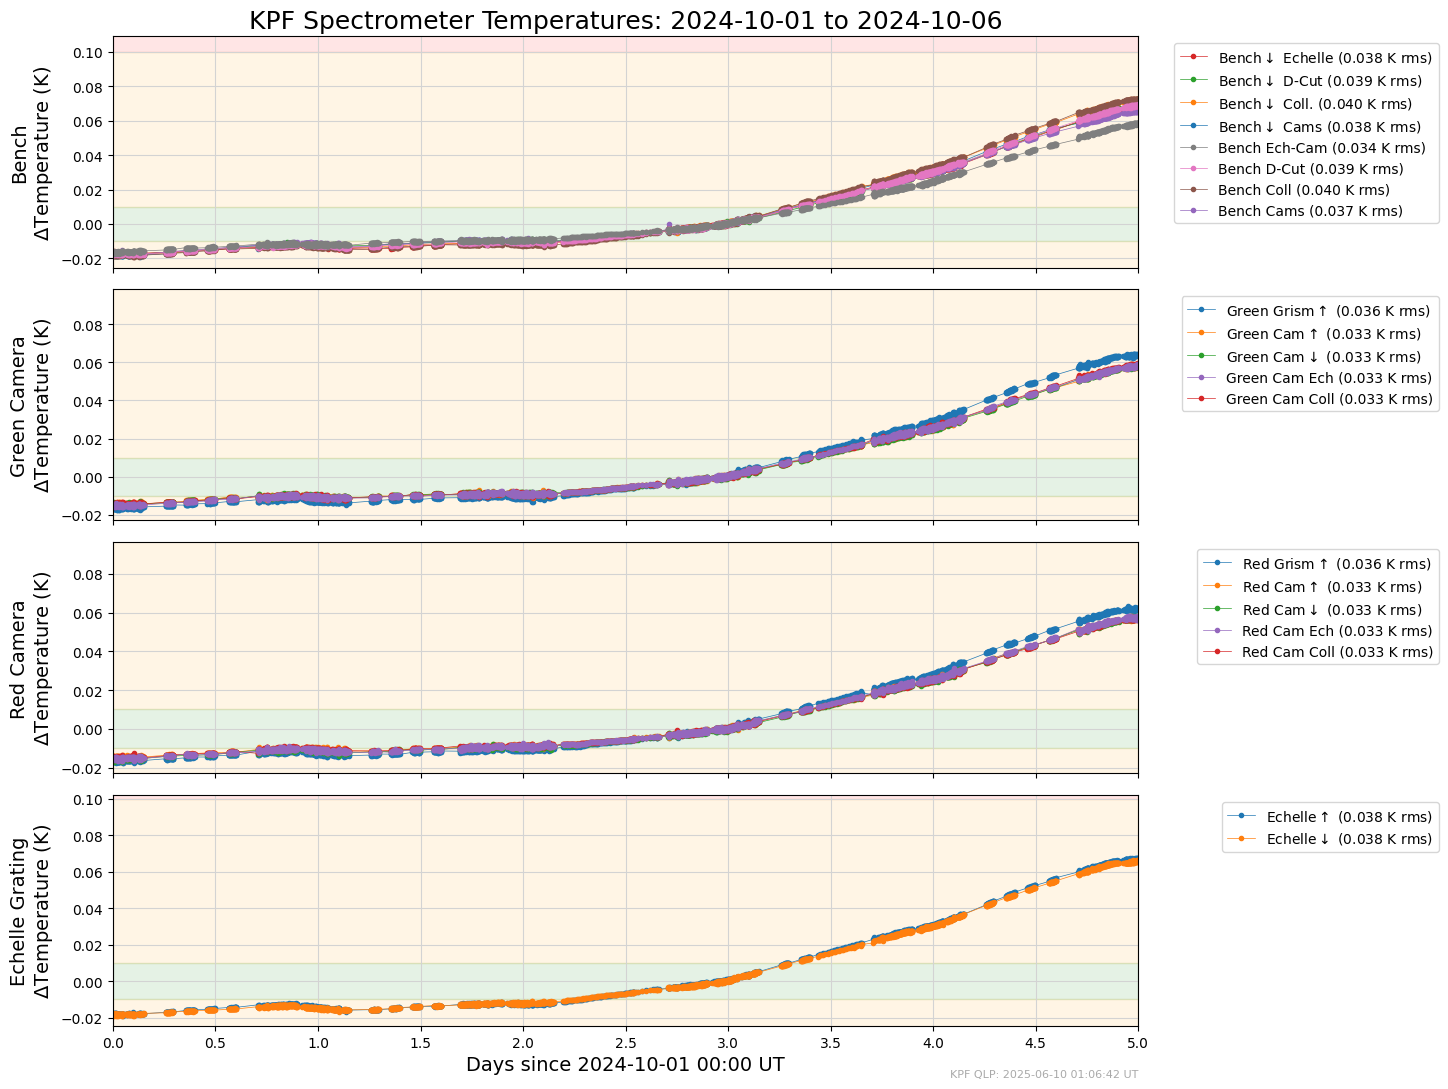

In [14]:
myTS.plot_time_series_multipanel('chamber_temp_detail', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

INFO: Plotting from config: /code/KPF-Pipeline/static/tsdb_plot_configs/CCDs/ccd_temp.yaml


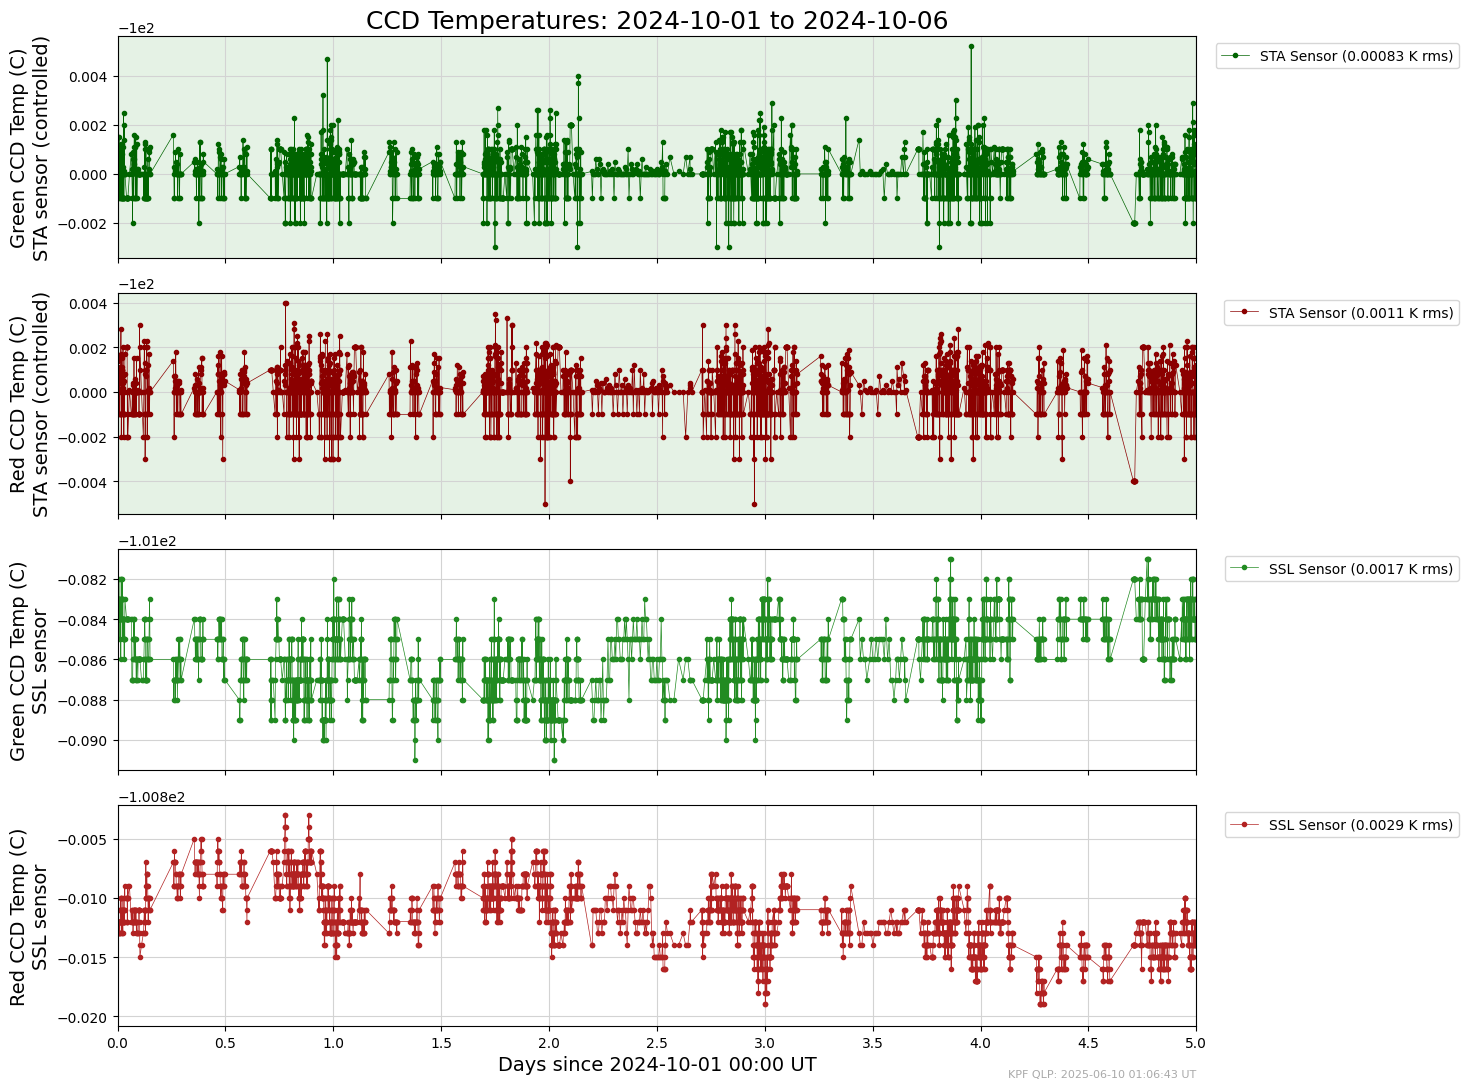

In [15]:
myTS.plot_time_series_multipanel('ccd_temp', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

The examples above are all plots of float-type variables (e.g., temperatures) over time.  The two below sho examples of state variables changing over time (the DRP version number used to process the data and the result of a quality control test).

INFO: Plotting from config: /code/KPF-Pipeline/static/tsdb_plot_configs/DRP/drptag.yaml


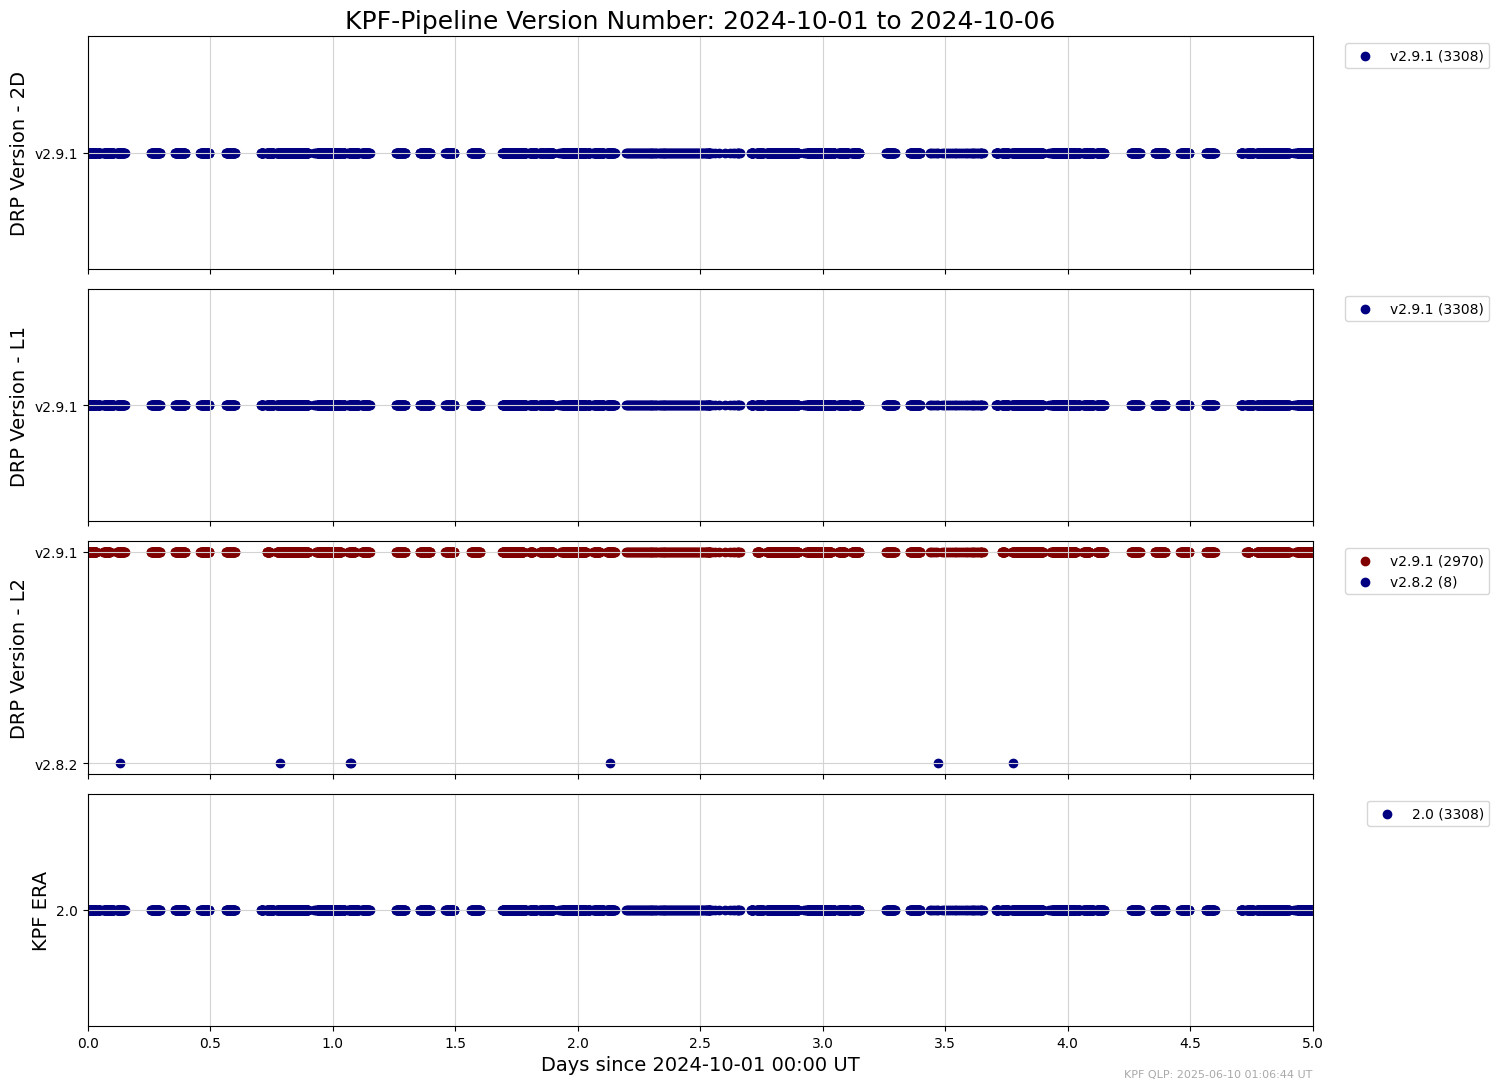

In [16]:
myTS.plot_time_series_multipanel('drptag', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

INFO: Plotting from config: /code/KPF-Pipeline/static/tsdb_plot_configs/QC/qc_monotonic_wls.yaml


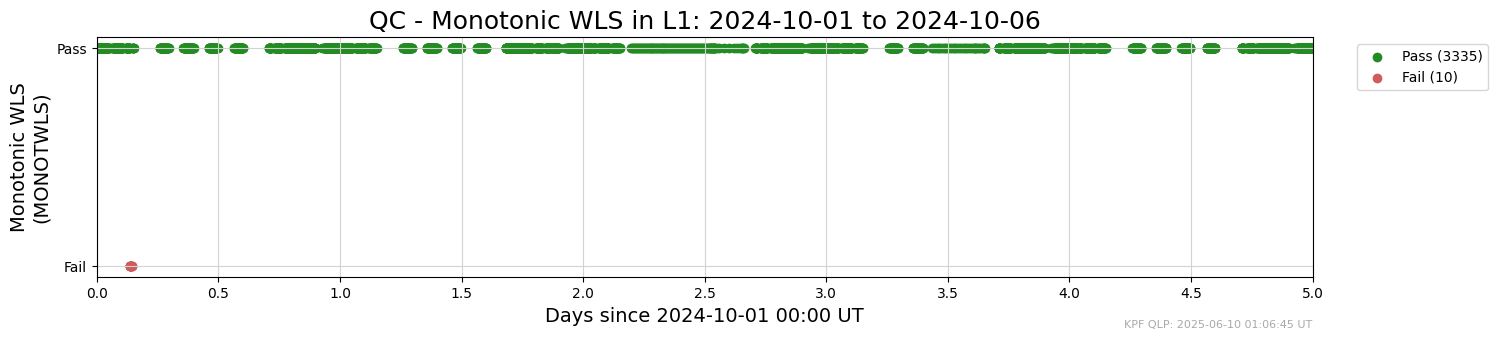

In [17]:
myTS.plot_time_series_multipanel('qc_monotonic_wls', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

## Plotting RVs

An example of plotting RVs (instead of telemetry) is shown below.

INFO: Plotting from config: /code/KPF-Pipeline/static/tsdb_plot_configs/RV/autocal_etalon_rv.yaml


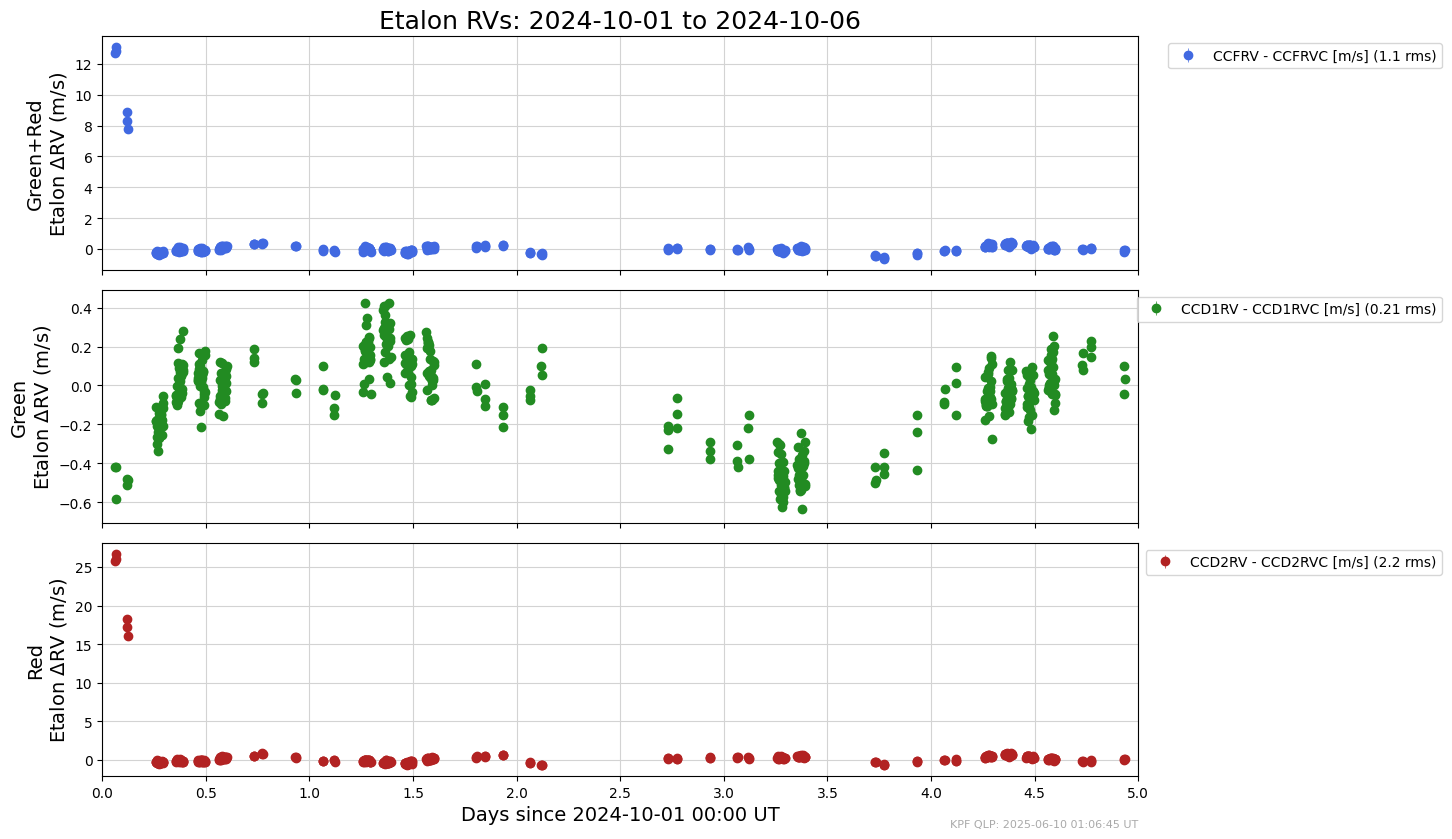

In [18]:
myTS.plot_time_series_multipanel('autocal_etalon_rv', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

Here's an example of plotting SoCal RV and spectral SNR time series.

INFO: Plotting from config: /code/KPF-Pipeline/static/tsdb_plot_configs/RV/socal_rv.yaml


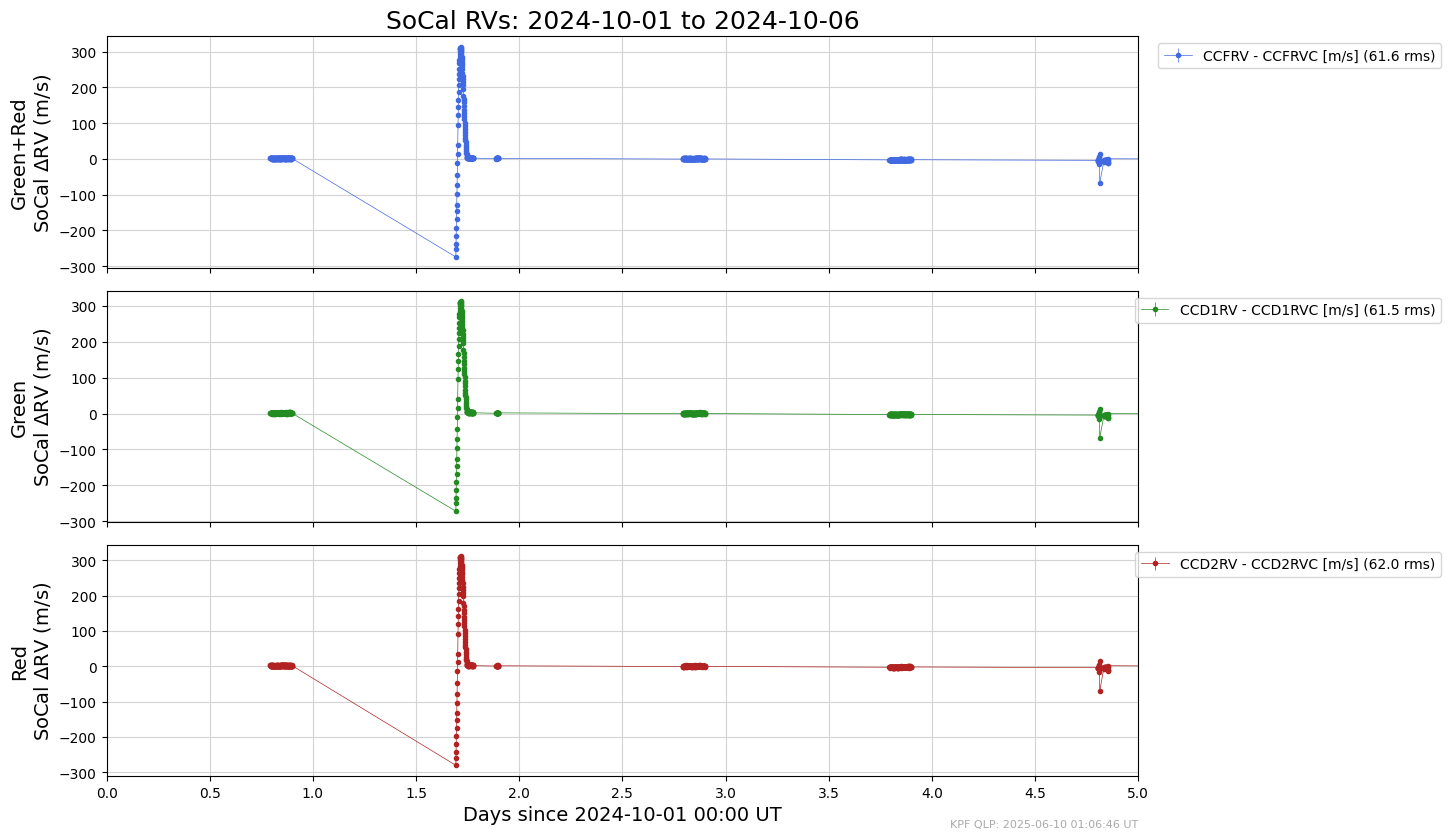

INFO: Plotting from config: /code/KPF-Pipeline/static/tsdb_plot_configs/SoCal/socal_snr.yaml


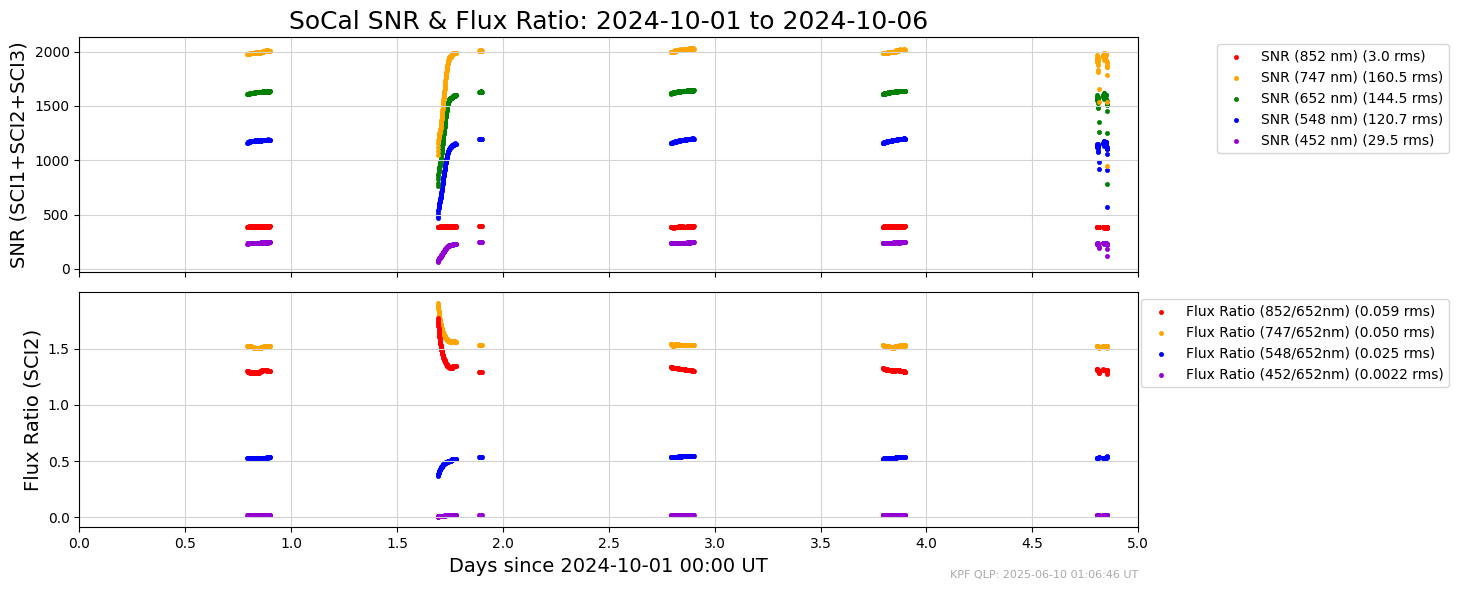

In [19]:
myTS.plot_time_series_multipanel('socal_rv',  start_date=start_date, end_date=end_date, show_plot=True, clean=True)
myTS.plot_time_series_multipanel('socal_snr', start_date=start_date, end_date=end_date, show_plot=True, clean=True)    

One can also plot information about on-sky conditions.

INFO: Plotting from config: /code/KPF-Pipeline/static/tsdb_plot_configs/Observing/seeing.yaml


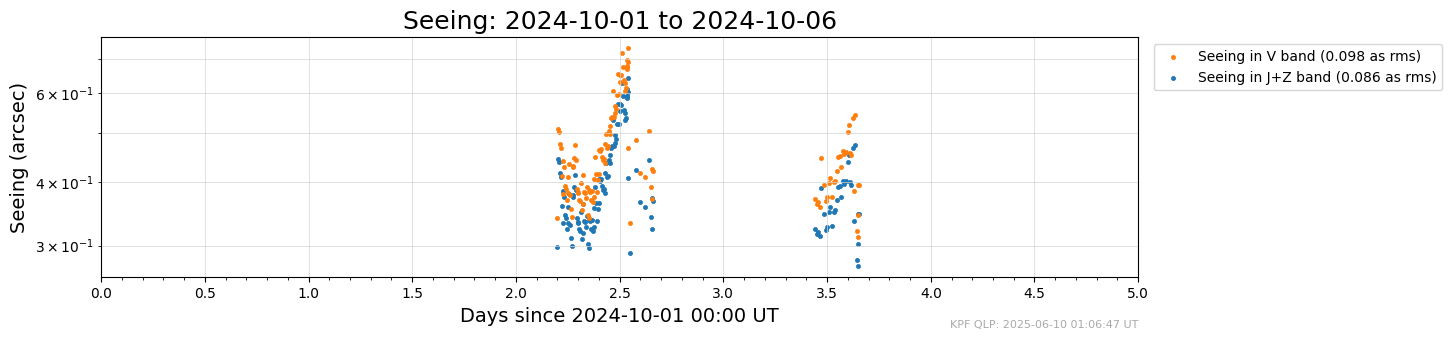

INFO: Plotting from config: /code/KPF-Pipeline/static/tsdb_plot_configs/Observing/sun_moon.yaml


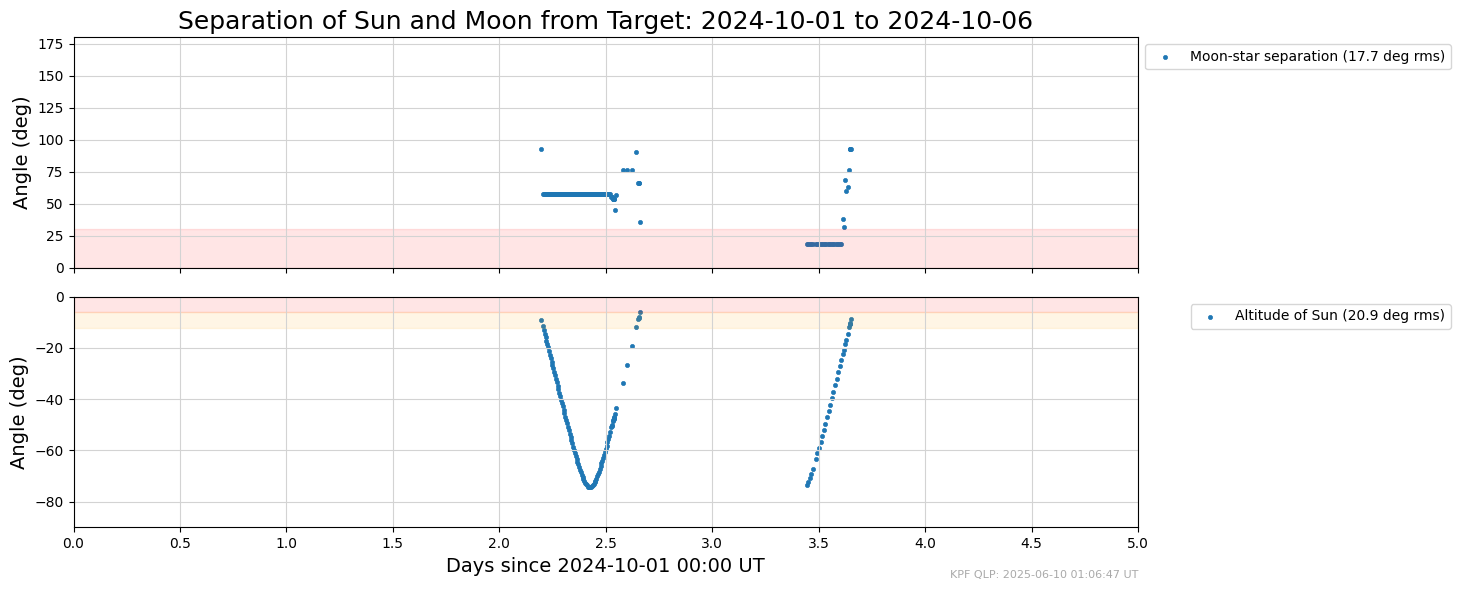

In [20]:
myTS.plot_time_series_multipanel('seeing',   start_date=start_date, end_date=end_date, show_plot=True, clean=True)
myTS.plot_time_series_multipanel('sun_moon', start_date=start_date, end_date=end_date, show_plot=True, clean=True)    

## Making Histograms of the Number Observations Over Time

Make a plot of the number of observations for the whole time span that's been ingested.

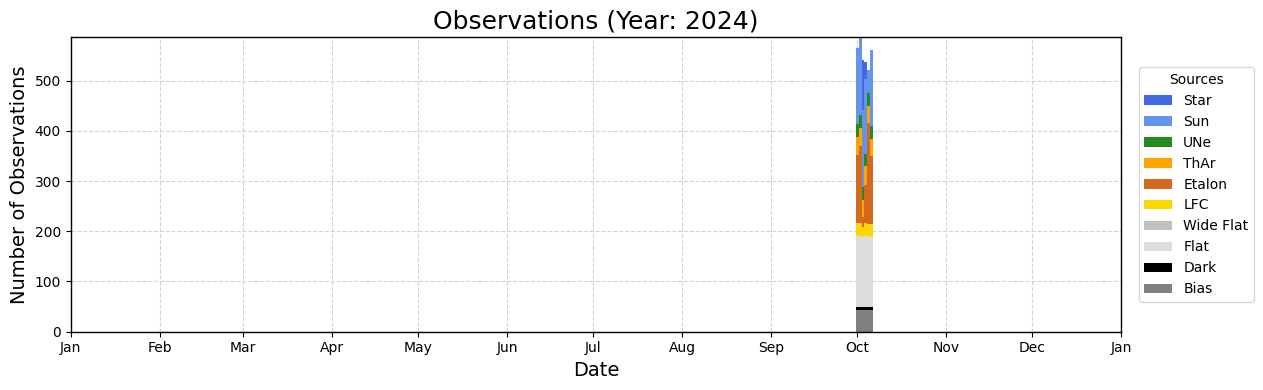

In [21]:
myTS.plot_nobs_histogram(interval='year', date='20241002', show_plot=True, plot_source=True)

Show the observations by type for the that month and one day.

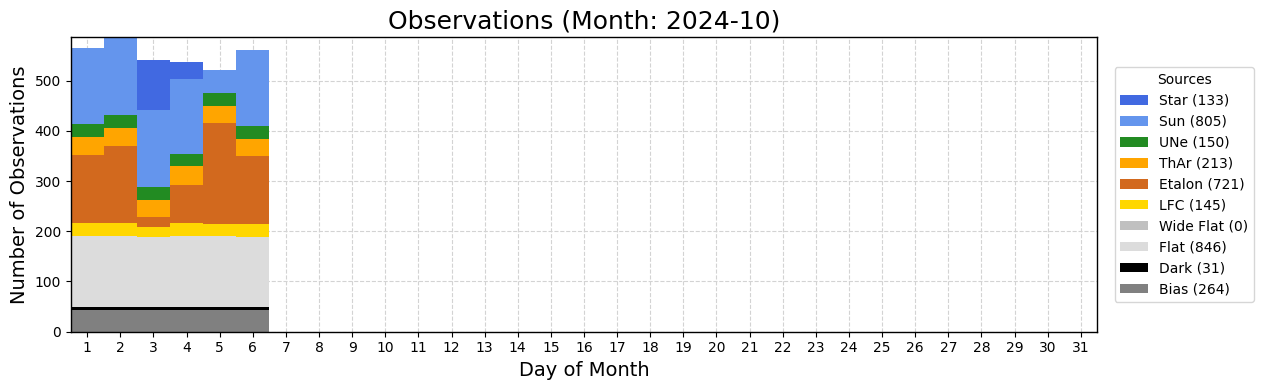

In [22]:
myTS.plot_nobs_histogram(interval='month', date='20241002', plot_source=True, show_plot=True)

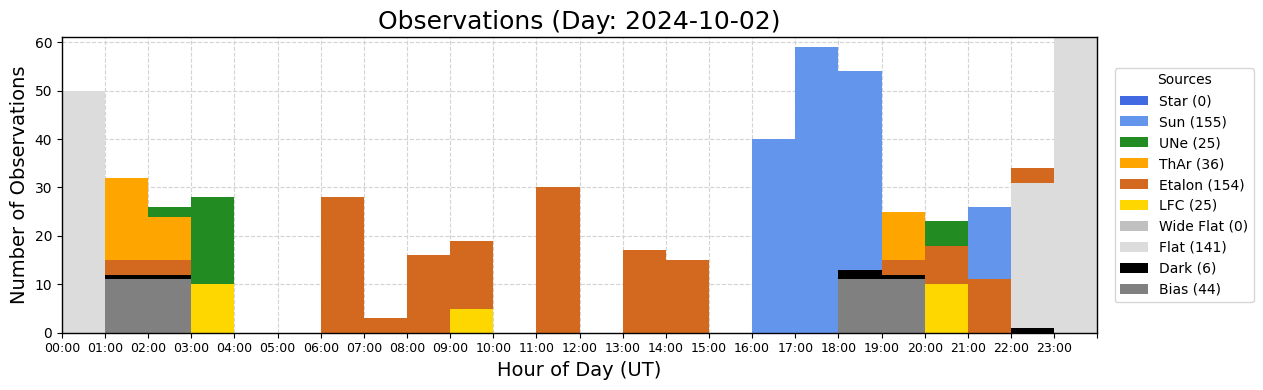

In [23]:
myTS.plot_nobs_histogram(interval='day', date='20241002', plot_source=True, show_plot=True)

Show the number of observations of just one source over a month.

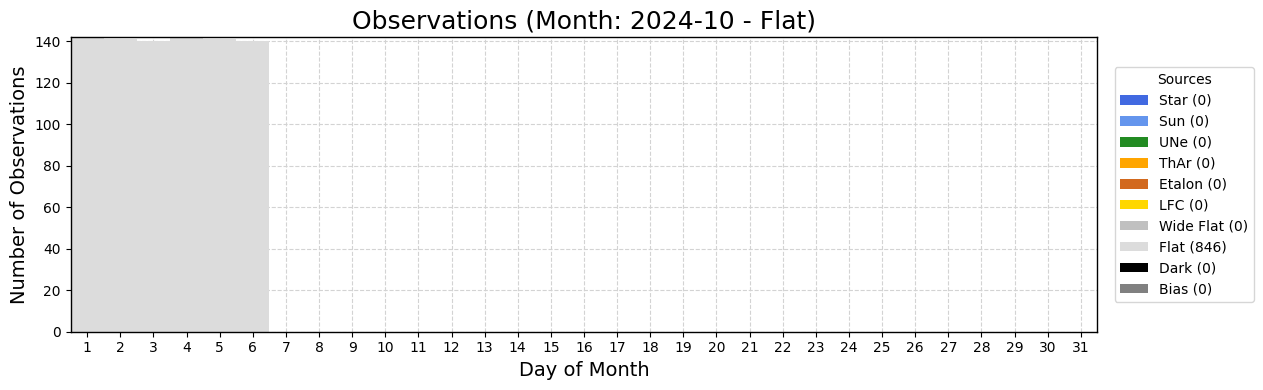

In [24]:
myTS.plot_nobs_histogram(interval='month', date='20241002', plot_source=True, show_plot=True, only_sources=['Flat'])

Show the number of stell observations per UT night.

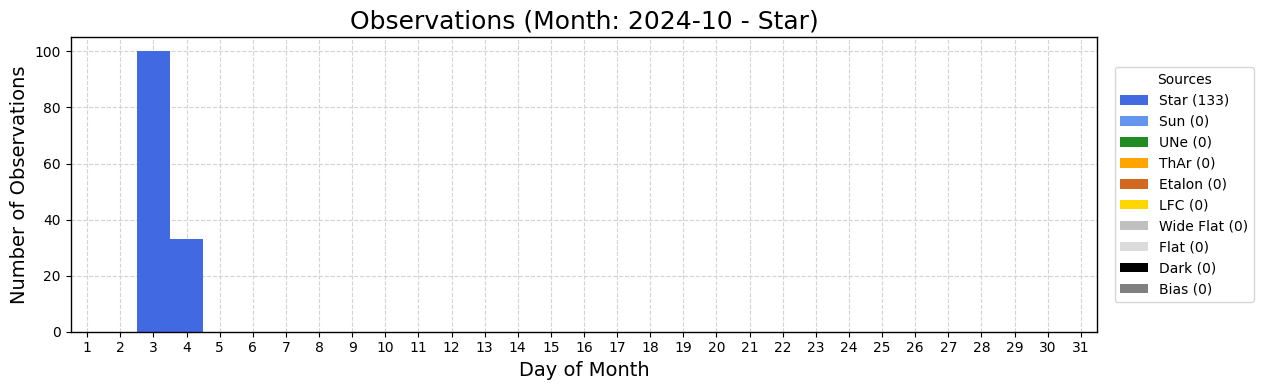

In [25]:
myTS.plot_nobs_histogram(interval='month', date='20241002', plot_source=True, show_plot=True, only_sources=['Star'])

## The Full Set of Standard Plots
There are also a number of standard plots based on YAML files in subdirectories of `KPF-Pipeline/static/tsdb_plot_configs/`.  The full set is listed below.

In [26]:
myTS.plot_all_quicklook(print_plot_names=True)

Plots available:
    'ccd_controller': CCD Controller Temperatures
    'ccd_dark_current': CCD Dark Current
    'ccd_readnoise': CCD Read Noise
    'ccd_readspeed': CCD Read Speed
    'xdisp_offset': CCD Cross Dispersion Offsets
    'ccd_temp': CCD Temperatures
    'autocal-flat_snr': autocal-flat-all SNR & Flux Ratio
    'autocal-flat_snr_relative': autocal-flat-all Relative SNR Ratio
    'lamp_power': Power Meter Measurements of Lamp Brightness
    'autocal-flat_flux_relative': autocal-flat-all Relative Flux Ratio
    'hcl': Hollow-Cathode Lamp Temperatures
    'good_orders_etalon': Good Orders - Etalon
    'good_orders_lfc': Good Orders - LFC
    'saturated_etalon': Saturated Lines - Etalon
    'saturated_lfc': Saturated Lines - LFC
    'saturated_thar': Saturated Lines - ThAr
    'saturated_une': Saturated Lines - Une
    'lfc': LFC Diagnostics
    'chamber_temp': KPF Spectrometer Temperatures
    'chamber_temp_detail': Chamber Temperature Detail
    'hallway_temp': KPF Hallway Tem

## Generating All Standard Plots
One can also generate all plots from the `plot_all_quicklook_daterange()` method with a single call.  It is in an if statement below so that be disabled because it generates a large number of plots (a few dozen) that may be more than are desired.  Toggle `if False:` to `if True:` to show the output.

In [27]:
if False:
    myTS = AnalyzeTimeSeries(db_path=db_path)
    myTS.plot_all_quicklook(datetime(2024, 10, 3), interval='day', show_plot=True, verbose=True)